In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt 

In [3]:
with open('../data/team_map.json', 'r') as file:
    team_map_dict = json.load(file)
result_cols = ['result_A', 'result_D', 'result_H']

In [4]:
df = pd.read_csv('../data/preprocessed/layer1/matches_stats_data_1.csv')

In [5]:
df = df[[col for col in df if col not in result_cols]+[col for col in result_cols if col in df]]
df['season'] = df['season'].apply(lambda x:  int(x[2:4]) - 19)

In [6]:
df['result_H'] = df['result_H'].apply(lambda x: 1 if x else 0)
df['result_A'] = df['result_A'].apply(lambda x: 1 if x else 0)
df['result_D'] = df['result_D'].apply(lambda x: 1 if x else 0)

In [7]:
df

,hometeam,awayteam,date,season,round,gf,ga,h_xg,h_xga,h_standard sot,...,a_overall_rating,a_attack_rating,a_midfield_rating,a_defence_rating,a_avg_age,soh,soa,result_A,result_D,result_H
0,CRY,SOU,2020-09-12,1,1,1.0,0.0,0.157143,0.128571,0.1875,...,0.250000,0.333333,0.3750,0.333333,0.562586,0.353518,0.349016,0,0,1
1,FUL,ARS,2020-09-12,1,1,0.0,3.0,0.014286,0.271429,0.1250,...,0.583333,0.666667,0.5000,0.533333,0.375516,0.353518,0.491616,1,0,0
2,LIV,LEE,2020-09-12,1,1,4.0,3.0,0.385714,0.042857,0.2500,...,0.250000,0.388889,0.3125,0.266667,0.425034,0.514222,0.415563,0,0,1
3,WHU,NEW,2020-09-12,1,1,0.0,2.0,0.142857,0.228571,0.1875,...,0.250000,0.333333,0.2500,0.200000,0.675378,0.494134,0.320495,1,0,0
4,TOT,EVE,2020-09-13,1,1,0.0,1.0,0.157143,0.171429,0.3125,...,0.500000,0.555556,0.5000,0.600000,0.662999,0.453958,0.377536,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,SOU,EVE,2024-11-02,5,10,1.0,0.0,0.100000,0.228571,0.1250,...,0.250000,0.277778,0.3125,0.333333,1.000000,0.270891,0.277075,0,0,1
1616,WOL,CRY,2024-11-02,5,10,2.0,2.0,0.214286,0.342857,0.3750,...,0.416667,0.388889,0.4375,0.400000,0.449794,0.817935,0.571101,0,1,0
1617,MUN,CHE,2024-11-03,5,10,1.0,1.0,0.285714,0.157143,0.1875,...,0.666667,0.555556,0.6250,0.533333,0.088033,0.515520,0.722152,0,1,0
1618,TOT,AVL,2024-11-03,5,10,4.0,1.0,0.342857,0.257143,0.3750,...,0.583333,0.777778,0.5625,0.600000,0.562586,0.559673,0.480735,0,0,1


In [8]:
df.columns

Index(['hometeam', 'awayteam', 'date', 'season', 'round', 'gf', 'ga', 'h_xg',
       'h_xga', 'h_standard sot', 'h_kp', 'h_xa', 'h_poss_x',
       'h_touches att pen', 'h_carries prgdist', 'h_progressive passing dist',
       'h_tackles tklw', 'h_challenges tkl%', 'h_saves', 'a_xg', 'a_xga',
       'a_standard sot', 'a_kp', 'a_xa', 'a_poss_x', 'a_touches att pen',
       'a_carries prgdist', 'a_progressive passing dist', 'a_tackles tklw',
       'a_challenges tkl%', 'a_saves', 'b365h', 'b365d', 'b365a',
       'h_strength_overall_home', 'h_overall_rating', 'h_attack_rating',
       'h_midfield_rating', 'h_defence_rating', 'h_avg_age',
       'a_strength_overall_away', 'a_overall_rating', 'a_attack_rating',
       'a_midfield_rating', 'a_defence_rating', 'a_avg_age', 'soh', 'soa',
       'result_A', 'result_D', 'result_H'],
      dtype='object')

In [9]:
home_columns = ['result_H',
                'gf','ga', 
                'h_xg',
                'h_xga', 'h_standard sot', 'h_kp', 'h_xa', 'h_poss_x',
                'h_touches att pen', 'h_carries prgdist', 'h_progressive passing dist',
                'h_tackles tklw', 'h_challenges tkl%', 'h_saves',
                'h_strength_overall_home', 'h_overall_rating', 'h_attack_rating',
                'h_midfield_rating', 'h_defence_rating', 'h_avg_age','soh']
away_columns = ['result_A',
                'ga','gf',
                'a_xg', 
                'a_xga','a_standard sot', 'a_kp', 'a_xa', 'a_poss_x', 
                'a_touches att pen','a_carries prgdist', 'a_progressive passing dist', 
                'a_tackles tklw','a_challenges tkl%', 'a_saves',
                'a_strength_overall_away', 'a_overall_rating', 'a_attack_rating',
                'a_midfield_rating', 'a_defence_rating', 'a_avg_age', 'soa']
bet_columns = ['b365h', 'b365d', 'b365a']

In [10]:
df = df.drop(columns='date')
df

,hometeam,awayteam,season,round,gf,ga,h_xg,h_xga,h_standard sot,h_kp,...,a_overall_rating,a_attack_rating,a_midfield_rating,a_defence_rating,a_avg_age,soh,soa,result_A,result_D,result_H
0,CRY,SOU,1,1,1.0,0.0,0.157143,0.128571,0.1875,0.166667,...,0.250000,0.333333,0.3750,0.333333,0.562586,0.353518,0.349016,0,0,1
1,FUL,ARS,1,1,0.0,3.0,0.014286,0.271429,0.1250,0.100000,...,0.583333,0.666667,0.5000,0.533333,0.375516,0.353518,0.491616,1,0,0
2,LIV,LEE,1,1,4.0,3.0,0.385714,0.042857,0.2500,0.466667,...,0.250000,0.388889,0.3125,0.266667,0.425034,0.514222,0.415563,0,0,1
3,WHU,NEW,1,1,0.0,2.0,0.142857,0.228571,0.1875,0.366667,...,0.250000,0.333333,0.2500,0.200000,0.675378,0.494134,0.320495,1,0,0
4,TOT,EVE,1,1,0.0,1.0,0.157143,0.171429,0.3125,0.300000,...,0.500000,0.555556,0.5000,0.600000,0.662999,0.453958,0.377536,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,SOU,EVE,5,10,1.0,0.0,0.100000,0.228571,0.1250,0.300000,...,0.250000,0.277778,0.3125,0.333333,1.000000,0.270891,0.277075,0,0,1
1616,WOL,CRY,5,10,2.0,2.0,0.214286,0.342857,0.3750,0.300000,...,0.416667,0.388889,0.4375,0.400000,0.449794,0.817935,0.571101,0,1,0
1617,MUN,CHE,5,10,1.0,1.0,0.285714,0.157143,0.1875,0.233333,...,0.666667,0.555556,0.6250,0.533333,0.088033,0.515520,0.722152,0,1,0
1618,TOT,AVL,5,10,4.0,1.0,0.342857,0.257143,0.3750,0.333333,...,0.583333,0.777778,0.5625,0.600000,0.562586,0.559673,0.480735,0,0,1


In [11]:
def prepare_data(ssdf: pd.DataFrame, prematch: int = 5) -> dict:
    a_teams_data = {}
    h_teams_data = {}
    team_idx = sorted(df['hometeam'].unique())
    final = {}
    for idx in team_idx:
        h_teams_data[idx] = []
        a_teams_data[idx] = []
        final[idx] = {'HOME':{}, 'AWAY':{}}
    for idx, match in ssdf.iterrows():
        hometeam = match['hometeam']
        awayteam = match['awayteam']
        
        tmp_h_data = match[['hometeam', 'awayteam']+home_columns+bet_columns]
        tmp_h_data['home'] = 1
        tmp_h_data['opponent'] = awayteam
        h_teams_data[hometeam].append(tmp_h_data.values)
        
        tmp_a_data = match[['hometeam', 'awayteam']+away_columns+bet_columns]
        tmp_a_data['home'] = 0
        tmp_a_data['opponent'] = hometeam
        a_teams_data[awayteam].append(tmp_a_data.values)
    
    for team,matches in h_teams_data.items():
        for idx in range(1,len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = pre_match_data[-1][0] + pre_match_data[-1][1]
            pre_match_data = np.vstack(pre_match_data)
            final[team]['HOME'][pre_match_data_key] = [pre_match_data[:, 2:-1], pre_match_data[-1][-1]]
            
    for team,matches in a_teams_data.items():
        for idx in range(1,len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = pre_match_data[-1][0] + pre_match_data[-1][1]
            pre_match_data = np.vstack(pre_match_data)
            final[team]['AWAY'][pre_match_data_key] = [pre_match_data[:, 2:-1], pre_match_data[-1][-1]]
    return final

In [12]:
ss2021 = df[df['season'] == 1]
final_dict = prepare_data(ss2021)

In [13]:
final_dict['ARS']['HOME']

{'ARSSHU': [array([[1, 2.0, 1.0, 0.1571428571428571, 0.2857142857142857, 0.1875, 0.2,
          0.4054054054054054, 0.6875, 0.2947368421052631,
          0.6296121097445601, 0.4982284001090215, 0.1851851851851851,
          0.545, 0.0769230769230769, 0.563380281690141, 0.583333333333333,
          0.6666666666666665, 0.5, 0.5333333333333332, 0.375515818431912,
          0.3785427744375856, 0.0261984392419174, 0.1666666666666666,
          0.1564967695620962, 1],
         [1, 2.0, 1.0, 0.0857142857142857, 0.0285714285714285, 0.3125, 0.2,
          0.1351351351351351, 0.71875, 0.1473684210526315,
          0.6717123935666982, 0.5731807031888798, 0.1481481481481481, 0.3,
          0.0769230769230769, 0.563380281690141, 0.583333333333333,
          0.6666666666666665, 0.5, 0.5333333333333332, 0.375515818431912,
          0.4198537993487464, 0.0284280936454849, 0.1176470588235294,
          0.1744436468054558, 1]], dtype=object),
  'SHU'],
 'ARSLEI': [array([[1, 2.0, 1.0, 0.1571428571428571

In [14]:
"""_structure_
    [This team win: 1/0][goal score][goal scored][rate-bet x3][home] = 26
    -------------------- TEAM 1__________________------------------- = 21 -> 42 +[this team home| other team home][rate-bet x3] = 47
"""

'_structure_\n    [This team win: 1/0][goal score][goal scored][rate-bet x3][home] = 26\n    -------------------- TEAM 1__________________------------------- = 21 -> 42 +[this team home| other team home][rate-bet x3] = 47\n'

In [15]:
def create_X_y(final_dict: dict):
    checked_match = []
    X =np.empty((0,45))
    y = []
    data_dict = {}
    for team_idx in final_dict.keys():
        for match_key, match_data in final_dict[team_idx]['HOME'].items():
            match_dict = {}
            if match_key in checked_match:
                continue
            checked_match.append(match_key)
            team1_data = match_data[0]
            try:
                team2_data = final_dict[match_data[1]]['AWAY'][match_key][0]
            except KeyError:

                continue
            
            team1_home = (team1_data[-1][-1] == 1)
            h,d,a = team1_data[-1][-4:-1].tolist()
            if team1_home:
                bet_rate = np.array([h,d,a])
            else:
                bet_rate = np.array([a,d,h])
            weights_1 = np.ones(team1_data.shape[0]-1)/(team1_data.shape[0]-1)
            weights_2 = np.ones(team2_data.shape[0]-1)/(team2_data.shape[0]-1)
            team1_prematch = np.dot(weights_1, team1_data[:-1,1:-4]).reshape(-1)
            team2_prematch = np.dot(weights_2, team2_data[:-1,1:-4]).reshape(-1)
            prematch = np.concatenate((team1_prematch, team2_prematch))
            prematch = np.concatenate((prematch, bet_rate))
            
            this_match_res = 0 if team1_data[-1][0] == 1 else 1 if team2_data[-1][0] == 1 else 1
            X = np.vstack((X, prematch))
            y.append(this_match_res)
            
            match_dict['x'] = prematch
            match_dict['y'] = this_match_res
            data_dict[match_key] = match_dict
    y = np.asarray(y)
    return data_dict, X, y

In [16]:
def handle_data(ss: int, prematch:int = 5, seq: bool = False):
    global df
    tmpss=ss-19
    sscheck = df[df['season']==tmpss]
    finalss = prepare_data(sscheck, prematch=prematch)
    _, X, y = create_X_y(finalss)
    print(X.shape, y.shape)
    if seq:
        np.save(f'Layer_1/Data/inputs{ss}_{ss+1}_seq.npy',X)
        np.save(f'Layer_1/Data/outputs{ss}_{ss+1}_seq.npy',y)
    else:
        np.save(f'Layer_1/Data/inputs{ss}_{ss+1}_NH.npy',X)
        np.save(f'Layer_1/Data/outputs{ss}_{ss+1}_NH.npy',y)

In [17]:
handle_data(20,6)
handle_data(21,6)
handle_data(22,6)
handle_data(23,6)

(358, 45) (358,)
(360, 45) (360,)
(360, 45) (360,)
(359, 45) (359,)


In [18]:
input_21 = np.load('Layer_1/Data/inputs21_22_NH.npy', allow_pickle=True)
y_21 = np.load('Layer_1/Data/outputs21_22_NH.npy', allow_pickle=True)
input_22 = np.load('Layer_1/Data/inputs22_23_NH.npy', allow_pickle=True)
y_22 = np.load('Layer_1/Data/outputs22_23_NH.npy', allow_pickle=True)
input_23 = np.load('Layer_1/Data/inputs23_24_NH.npy', allow_pickle=True)
y_23 = np.load('Layer_1/Data/outputs23_24_NH.npy', allow_pickle=True)
y_23_3labels = np.load('Layer_1/Data/outputs23_24.npy', allow_pickle=True)

INPUTS = np.vstack((input_21,input_22))
# INPUTS = np.vstack((INPUTS, input_22_1_1))
LABELS = np.concatenate((y_21,y_22))
# LABELS = np.concatenate((LABELS, y_22))
train_X, test_X, train_y, test_y = train_test_split(INPUTS, LABELS, test_size = 0.2, shuffle = True)

0.6847222222222222


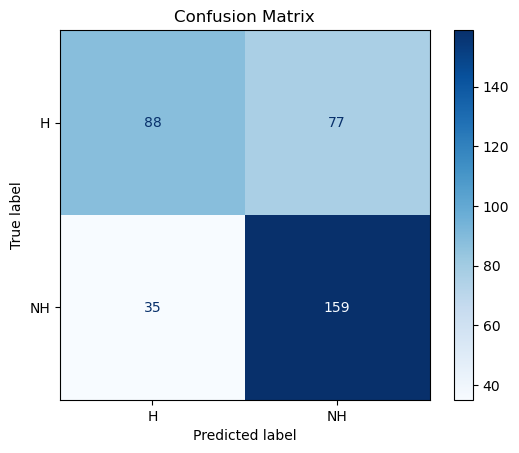

0.6880222841225627

In [19]:
svc_ovo = SVC(kernel='linear')
svc_ovo.fit(INPUTS, LABELS)
y_predict = svc_ovo.predict(input_23)
print(accuracy_score(LABELS, svc_ovo.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy_score(y_23, y_predict)

1.0


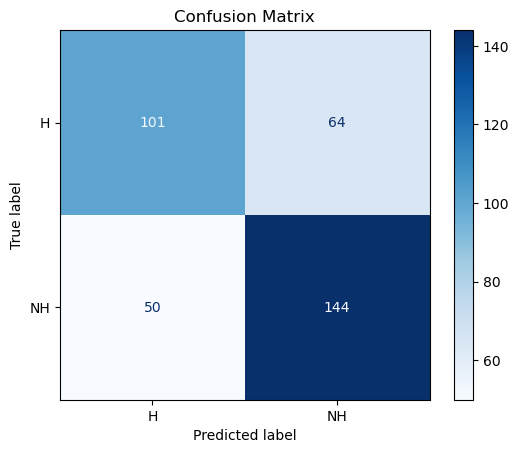

0.6824512534818942

In [20]:
rf_clf = RandomForestClassifier(criterion='entropy', random_state=42)
rf_clf.fit(INPUTS, LABELS)
y_predict = rf_clf.predict(input_23)
print(accuracy_score(LABELS, rf_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy_score(y_23, y_predict)


0.9347222222222222


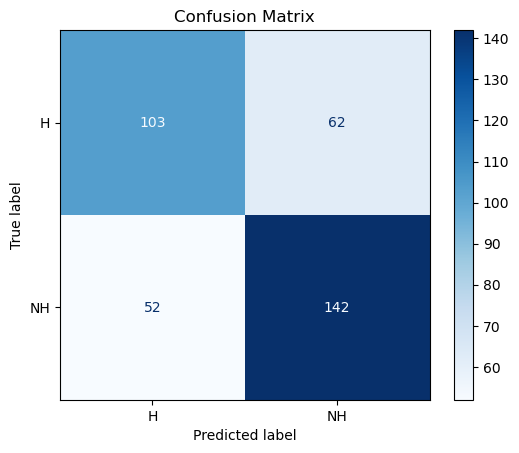

0.6824512534818942

In [21]:
xGboost_clf = GradientBoostingClassifier(random_state=42)
xGboost_clf.fit(INPUTS, LABELS)
y_predict = xGboost_clf.predict(input_23)
print(accuracy_score(LABELS, xGboost_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy_score(y_23, y_predict)


In [22]:
# import pickle

# # Save the model
# with open('Layer_1/Model/H_NH/SVM.pkl', 'wb') as f:
#     pickle.dump(svc_ovo, f)

# with open('Layer_1/Model/H_NH/RandomForest.pkl', 'wb') as f:
#     pickle.dump(rf_clf, f)
    
# with open('Layer_1/Model/H_NH/xGBoost.pkl', 'wb') as f:
#     pickle.dump(xGboost_clf, f)
